# Testing DrugAgent and DrugEnv APIs

Load data.

In [1]:
%reload_ext autoreload
%autoreload 2
import warnings
warnings.filterwarnings('ignore') 

import rdkit
import dgym as dg

# load all data
path = '../../dgym-data'

deck = dg.MoleculeCollection.load(
    f'{path}/DSi-Poised_Library_annotated.sdf',
    reactant_names=['reagsmi1', 'reagsmi2', 'reagsmi3']
)

reactions = dg.ReactionCollection.from_json(
    path = f'{path}/All_Rxns_rxn_library_sorted.json',
    smarts_col = 'reaction_string',
    classes_col = 'functional_groups'
)

building_blocks = dg.datasets.disk_loader(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630.sdf')
fingerprints = dg.datasets.fingerprints(f'{path}/Enamine_Building_Blocks_Stock_262336cmpd_20230630_atoms.fpb')

import torch
import pyarrow.parquet as pq
table = pq.read_table('../../dgym-data/sizes.parquet')[0]
sizes = torch.tensor(table.to_numpy())

Load assays and utility functions.

In [2]:
import os

def get_tcp_objectives():

    dockstring_dir = f'{path}/dockstring_targets/'
    files = os.listdir(dockstring_dir)
    configs = sorted([f for f in files if 'conf' in f])
    targets = sorted([f for f in files if 'target' in f])

    idx = 0
    with open(dockstring_dir + configs[idx], 'r') as f:
        config_ = f.readlines()
        config_ = [c.replace('\n', '') for c in config_]
        config_ = [c.split(' = ') for c in config_ if c]
        config_ = {c[0]: float(c[1]) for c in config_}

    target = targets[idx]
    name = target.split('_')[0]

    config_.update({
        'size_x': 22.5,
        'size_y': 22.5,
        'size_z': 22.5,
    })

    from dgym.envs.oracle import \
        DockingOracle, CatBoostOracle, RDKitOracle, NoisyOracle
    from dgym.envs.utility import ClassicUtilityFunction

    config = {
        'search_mode': 'detailed',
        'scoring': 'vina',
        'seed': 5,
        **config_
    }

    pIC50_oracle = DockingOracle(
        f'{name} pIC50',
        receptor_path=f'{path}/dockstring_targets/{name}_target.pdbqt',
        config=config
    )
    log_P_oracle = RDKitOracle('Log P', descriptor='MolLogP')
    log_S_oracle = CatBoostOracle(
        'Log S', path='../dgym/envs/models/aqsolcb.model')
    
    return pIC50_oracle, log_P_oracle, log_S_oracle

In [3]:
from dgym.envs.utility import ClassicUtilityFunction, MultipleUtilityFunction

# Get objectives
pIC50_oracle, log_P_oracle, log_S_oracle = get_tcp_objectives()

# Define utility functions
pIC50_utility = ClassicUtilityFunction(
    pIC50_oracle, ideal=(9.5, 13), acceptable=(8, 13))
log_P_utility = ClassicUtilityFunction(
    log_P_oracle, ideal=(0.5, 1.85), acceptable=(-0.5, 3.5))
log_S_utility = ClassicUtilityFunction(
    log_S_oracle, ideal=(-3, 1), acceptable=(-4, 1))

# Assemble assays and surrogate models
assays = [
    pIC50_oracle,
    log_P_oracle,
    log_S_oracle,
    pIC50_oracle.surrogate(sigma=1.0),
    log_P_oracle.surrogate(sigma=1.0),
    log_S_oracle.surrogate(sigma=1.0),
]

# Environment tolerates acceptable ADMET
from copy import deepcopy
utility_agent = MultipleUtilityFunction(
    utility_functions = [pIC50_utility, log_P_utility, log_S_utility],
    weights = [0.8, 0.1, 0.1]
)
utility_env = deepcopy(utility_agent)
utility_env.utility_functions[1].ideal = utility_env.utility_functions[1].acceptable
utility_env.utility_functions[2].ideal = utility_env.utility_functions[2].acceptable

Instantiate designer.

In [4]:
from dgym.envs.designer import Designer, Generator

designer = Designer(
    Generator(building_blocks, fingerprints, sizes),
    reactions,
    cache = True
)

Pick 5 random starting hits.

In [94]:
# select first molecule
import random
def select_molecule(deck):
    initial_index = random.randint(0, len(deck) - 1)
    initial_molecule = deck[initial_index]
    if len(initial_molecule.reactants) == 2 \
        and designer.match_reactions(initial_molecule):
        return initial_molecule
    else:
        return select_molecule(deck)

initial_molecules = [select_molecule(deck) for _ in range(5)]
library = dg.MoleculeCollection(initial_molecules).update_annotations()

# Score molecules
for assay in drug_env.assays.values():
    if 'Noisy' not in assay.name:
        results = assay(library)
        for molecule, result in zip(library, results):
            molecule.update_annotations({assay.name: result})

# Set status to tested
library.set_status('Tested', step=0)

Instantiate Environment and Agent.

In [95]:
from dgym.envs import DrugEnv
from dgym.agents import SequentialDrugAgent
from dgym.agents.exploration import EpsilonGreedy

drug_env = DrugEnv(
    designer = designer,
    library = library,
    assays = assays,
    utility_function = utility_env
)

# Construct sequence
design_grow = {'name': 'design', 'batch_size': 5, 'parameters': {'strategy': 'grow', 'size': 8}}
design_replace = {'name': 'design', 'batch_size': 5, 'parameters': {'strategy': 'replace', 'size': 8, 'temperature': 0.0}}
score = {'name': ['Noisy ABL1 pIC50', 'Noisy Log S', 'Noisy Log P'], 'batch_size': 40}
make = {'name': 'make', 'batch_size': 8}
test = {'name': ['ABL1 pIC50', 'Log S', 'Log P'], 'batch_size': 8}
design_and_score = [design_replace, score]

sequence = [*(design_and_score * 1), design_grow, score, make, test]

drug_agent = SequentialDrugAgent(
    sequence = sequence,
    exploration_strategy = EpsilonGreedy(epsilon=0.2),
    utility_function = utility_agent
)

In [96]:
def display_best():
    import numpy as np
    utilities = drug_env.utility_function(
        observations, use_precomputed=True, method='average')
    for obs, utility in zip(observations, utilities):
        obs.update_annotations({'utility': utility})
    tested = observations.tested
    if tested:
        best_tested = (
            tested
            .annotations
            .sort_values('utility', ascending=False)
            [['ABL1 pIC50', 'Log S', 'Log P', 'utility']]
            .head()
        )
        display(best_tested)

In [79]:
import json
from tqdm.notebook import tqdm

drug_agent.reset()
observations, _ = drug_env.reset()
for step in tqdm(range(200)):
    action = drug_agent.act(observations)
    observations, reward, truncated, terminated, _ = drug_env.step(action)

    if step % len(drug_agent.sequence) == 0:
        display_best()
        print('Designed:', len(observations.designed))
        print('Scored:', len(observations.scored))
        print('Made:', len(observations.made))
        print('Tested:', len(observations.tested))

  0%|          | 0/200 [00:00<?, ?it/s]

,ABL1 pIC50,Log S,Log P,utility
436,8.972843,-4.317906,3.7450,0.390160
779,8.537323,-4.099435,2.6654,0.365696
484,8.622989,-4.295483,3.0911,0.364433
460,8.634401,-4.578166,3.1406,0.289287
340,7.993428,-3.320577,1.2901,0.189450


Designed: 120
Scored: 712
Made: 0
Tested: 80


,ABL1 pIC50,Log S,Log P,utility
825,9.127974,-3.903549,1.6549,0.801586
436,8.972843,-4.317906,3.7450,0.390160
779,8.537323,-4.099435,2.6654,0.365696
484,8.622989,-4.295483,3.0911,0.364433
460,8.634401,-4.578166,3.1406,0.289287


Designed: 120
Scored: 784
Made: 0
Tested: 88


,ABL1 pIC50,Log S,Log P,utility
825,9.127974,-3.903549,1.6549,0.801586
981,8.370958,-3.320577,1.2901,0.397844
436,8.972843,-4.317906,3.7450,0.390160
779,8.537323,-4.099435,2.6654,0.365696
484,8.622989,-4.295483,3.0911,0.364433


Designed: 120
Scored: 856
Made: 0
Tested: 96


,ABL1 pIC50,Log S,Log P,utility
825,9.127974,-3.903549,1.6549,0.801586
981,8.370958,-3.320577,1.2901,0.397844
436,8.972843,-4.317906,3.7450,0.390160
973,8.336400,-3.349302,2.6722,0.379414
779,8.537323,-4.099435,2.6654,0.365696


Designed: 120
Scored: 928
Made: 0
Tested: 104


,ABL1 pIC50,Log S,Log P,utility
825,9.127974,-3.903549,1.6549,0.801586
981,8.370958,-3.320577,1.2901,0.397844
974,8.364088,-3.348085,2.6722,0.394180
436,8.972843,-4.317906,3.7450,0.390160
960,8.349964,-3.903549,1.6549,0.386647


Designed: 120
Scored: 1000
Made: 0
Tested: 112


KeyboardInterrupt: 

In [80]:
import seaborn as sns
drug_env.library.tested.annotations.reindex(
    columns=[*drug_env.assays, 'Current Status', 'Step Designed', 'Step Scored', 'Step Made', 'Step Tested'])

,ABL1 pIC50,Log P,Log S,Noisy ABL1 pIC50,Noisy Log P,Noisy Log S,Current Status,Step Designed,Step Scored,Step Made,Step Tested
7,7.127139,3.16410,-3.461987,8.454431,0.674857,-3.939692,Tested,0,0,1,1
9,6.784205,0.61310,-2.428007,7.495178,0.376486,-3.087693,Tested,0,0,3,3
10,6.360859,1.98370,-2.897551,7.527661,1.585412,-3.074029,Tested,0,0,2,2
14,6.539285,2.12960,-2.575288,7.831131,2.512777,-2.324938,Tested,0,0,1,1
23,6.491531,1.90940,-2.526963,8.048538,1.514758,-2.218815,Tested,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...,...
983,7.892567,0.94350,-2.735715,9.029657,-0.529428,-3.215640,Tested,11,12,14,14
985,8.027233,1.13430,-2.746739,8.171503,1.501770,-3.433064,Tested,11,12,13,13
988,8.020981,0.95967,-2.686692,9.040078,2.041665,-2.846893,Tested,11,12,13,13
1050,7.495563,2.25210,-4.006992,8.639674,0.450853,-3.752356,Tested,12,13,14,14


/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and 

<Figure size 1920x1440 with 0 Axes>

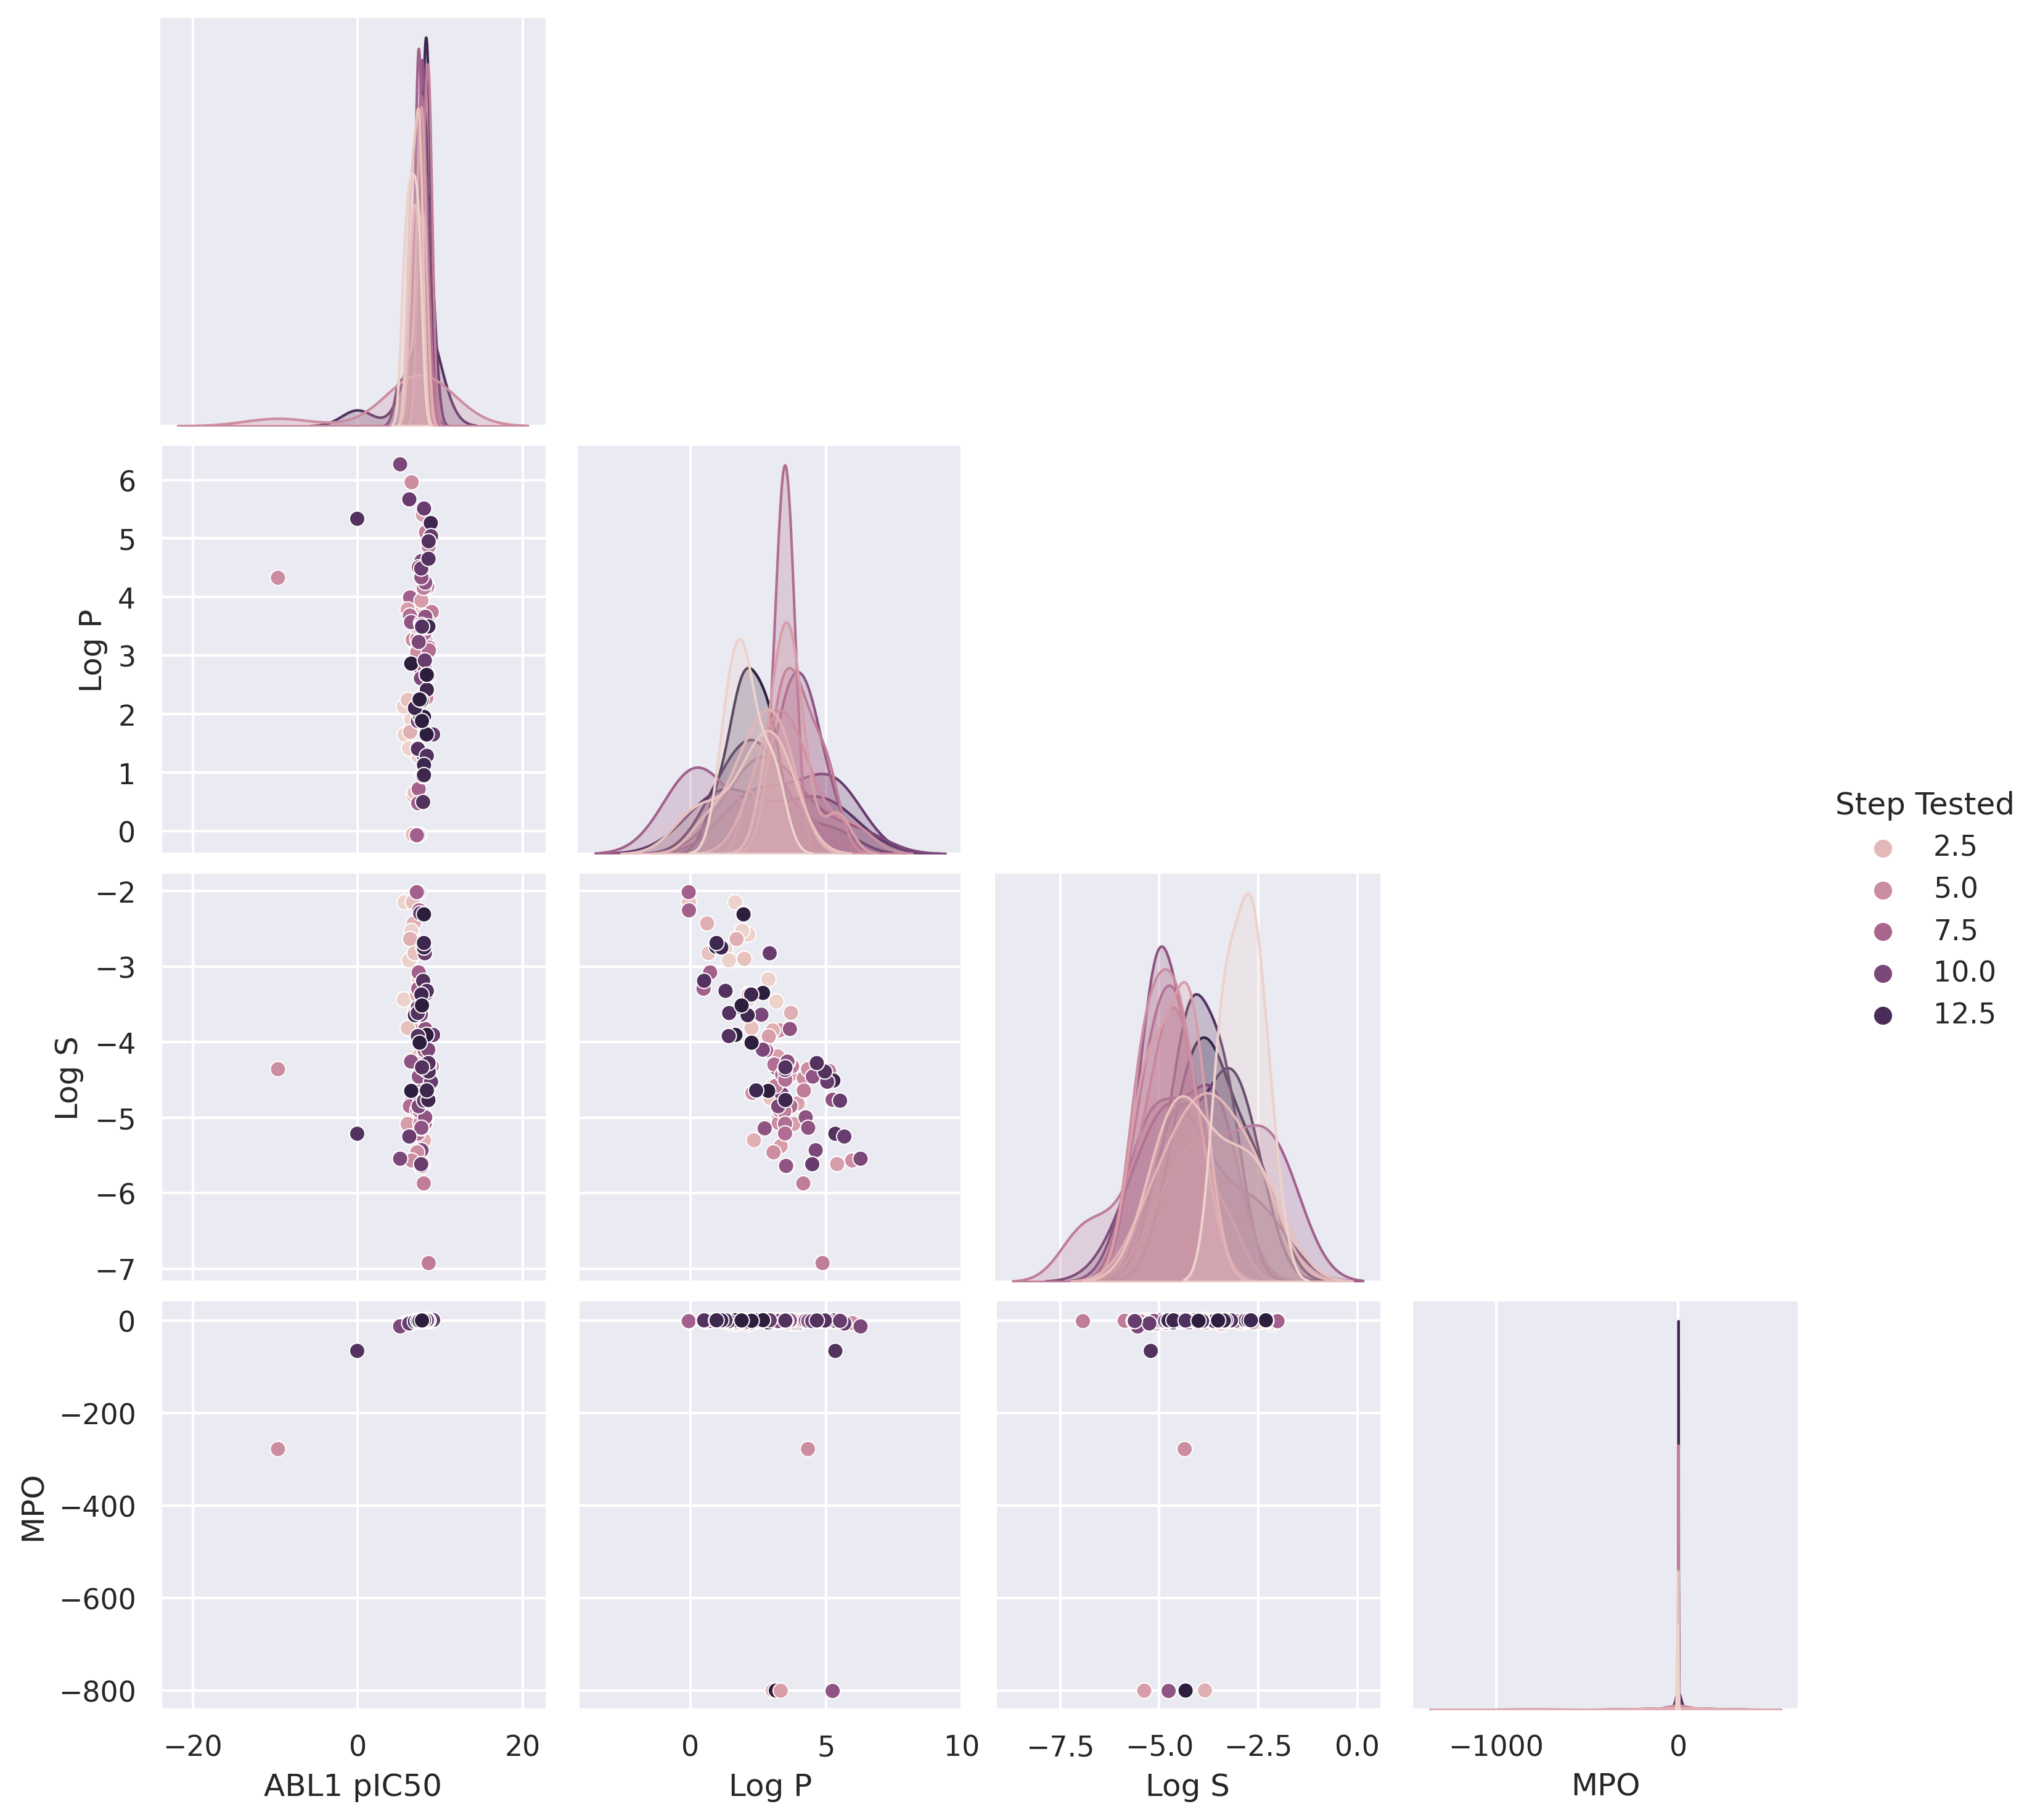

In [81]:
import numpy as np
import pandas as pd

plt.figure(dpi=300)

pairplot_df = drug_env.library.annotations[
    ['ABL1 pIC50', 'Log P', 'Log S', 'Step Tested']
]

pairplot_df['MPO'] = drug_env.utility_function(drug_env.library, use_precomputed=True, method='average')

sns.set_theme()
g = sns.pairplot(
    pairplot_df,
    corner=True,
    hue='Step Tested'
)
g.fig.set_dpi(300)

In [82]:
max_timestep = int(drug_env.library.annotations['Step Tested'].max())

objective = 'ABL1 pIC50'
records = []
for timestep, group in pairplot_df.groupby('Step Tested'):
    for _, mol in group.iterrows():
        record = {
            'pIC50': mol[objective], 'Step Tested': timestep}
        records.append(record)
        
        # Duplicate logic for each possible timestep
        for t in range(1, max_timestep + 1):
            if timestep < t:
                records.append({**record, 'Step Tested': t})

df = pd.DataFrame(records)

/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/home/mrr/miniconda3/envs/chodera/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: DeprecationWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, pd.CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):


Text(0.5, 1.0, 'Distribution of ligand potencies across rounds')

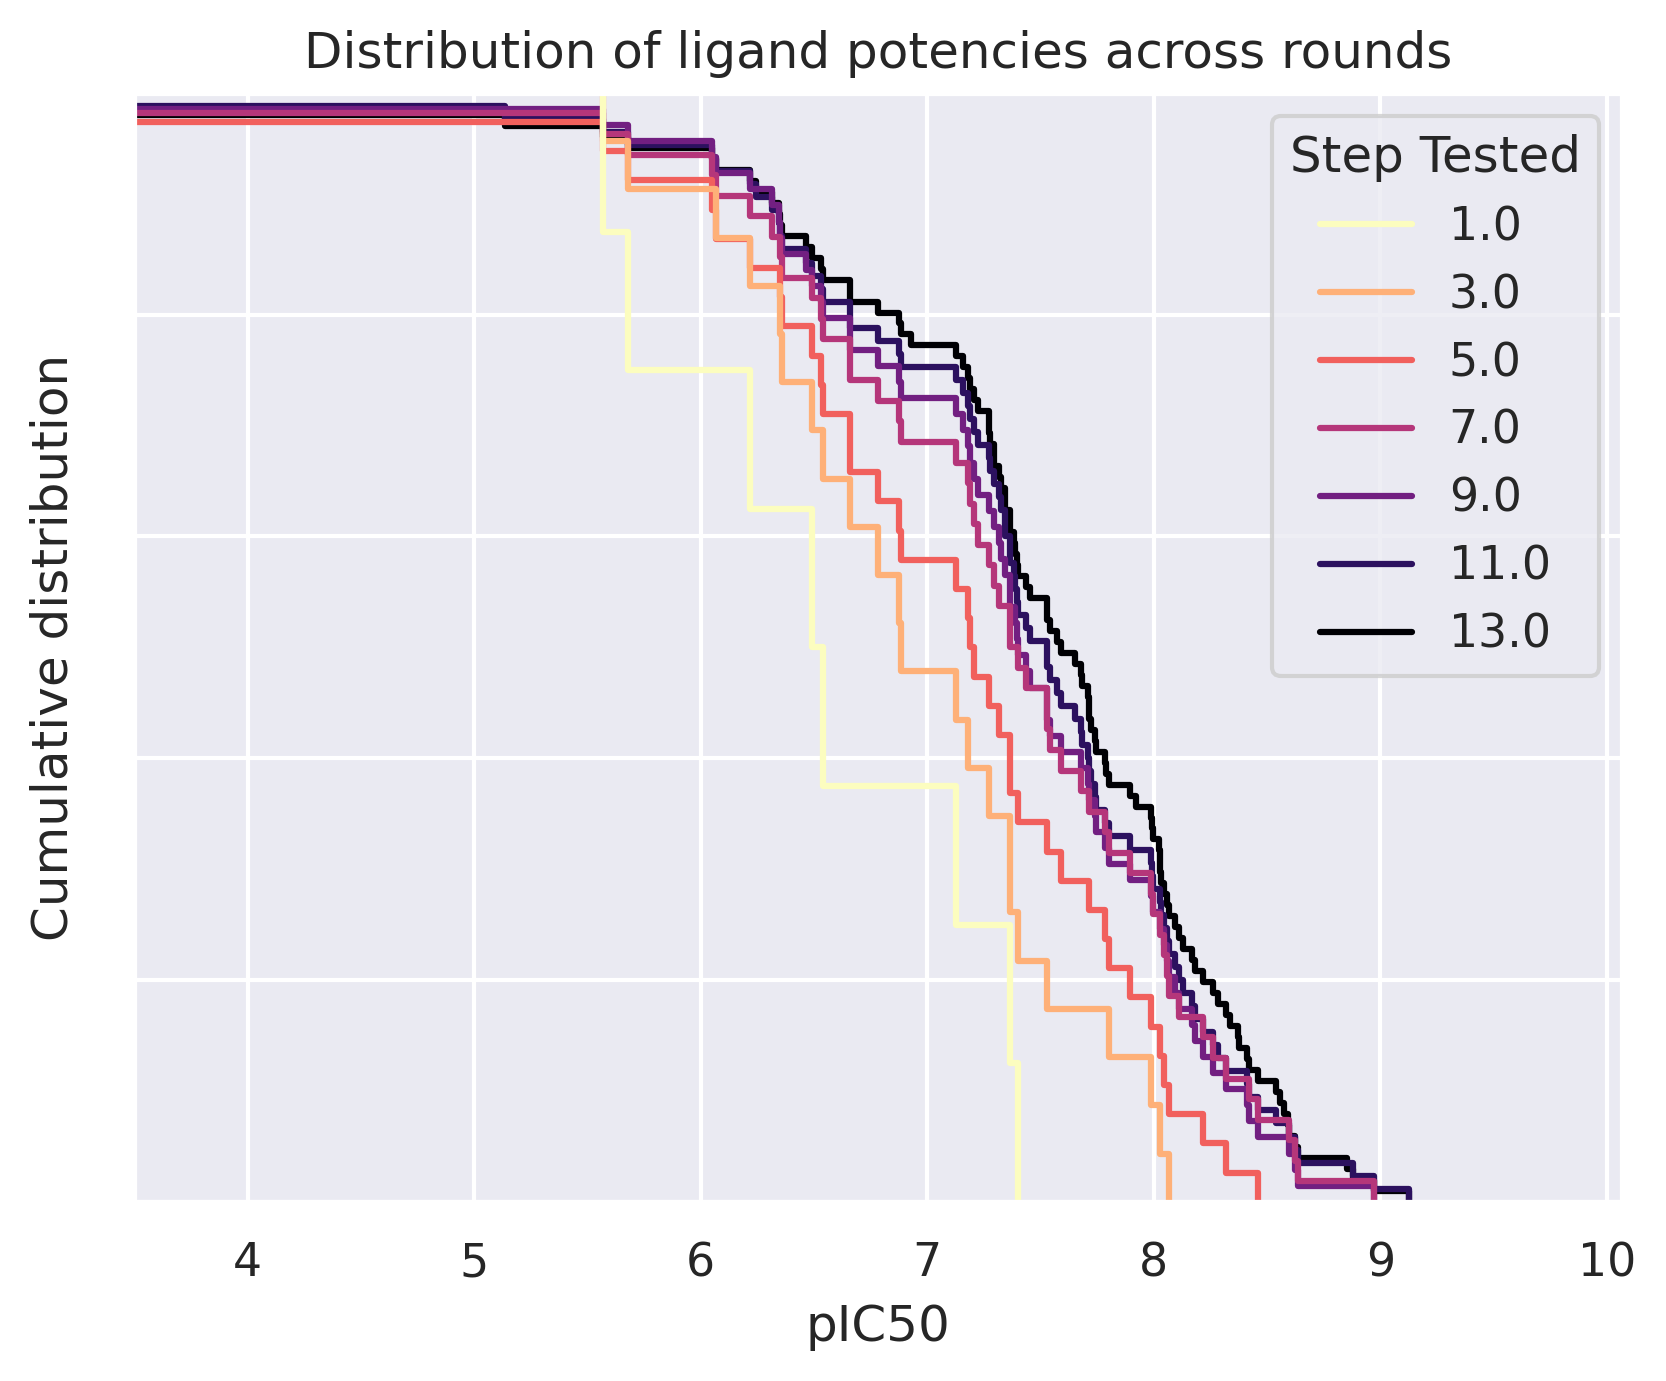

In [85]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set()
plt.figure(dpi=300)

g = sns.ecdfplot(
    df.query('`Step Tested` % 2 == 1'),
    x='pIC50',
    hue='Step Tested',
    palette='magma_r',
    complementary=True
)

g.set(yticklabels=[])

plt.xlim(3.5)
plt.xlabel('pIC50')
plt.ylabel('Cumulative distribution')
plt.title('Distribution of ligand potencies across rounds')